## 라이브러리 임포트

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading data

In [2]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [1486]:
my_data = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'REAL_ORD_QTY']]

In [1487]:
my_data['O_YMD'] = pd.to_datetime(my_data['O_YMD'])
my_data['O_YMD'] = my_data['O_YMD'].dt.weekday
my_data = my_data.sort_values('H_YMD')

my_data

,H_YMD,O_YMD,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01 00:00:00,0,14375,1,0,0,8600,1
37753,2020-01-01 00:00:00,0,1901012353,2,0,0,6300,2
162585,2020-01-01 00:00:00,0,1823,1,0,0,3300,1
164041,2020-01-01 00:00:00,0,1712010310,1,0,0,6900,1
164040,2020-01-01 00:00:00,0,1712010310,1,0,0,6900,1
...,...,...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,2,1803010879,1,0,0,4500,1
241774,2022-05-31 00:00:00,0,1909013359,1,0,0,9900,1
236656,2022-05-31 00:00:00,6,1803010879,1,0,0,4500,1
241810,2022-05-31 00:00:00,0,1909013359,1,0,0,9900,1


In [1490]:
my_data = my_data.groupby(['H_YMD', 'O_YMD', 'GOODS_NO'], as_index=True).count()

my_data[20:]

ORD_QTY  CANCEL_QTY  RET_QTY  \
H_YMD               O_YMD GOODS_NO                                   
2020-01-01 00:00:00 1     1808011751        1           1        1   
                          1901012353        1           1        1   
                          1903012675        1           1        1   
                          1909013359        1           1        1   
                    2     1823              1           1        1   
...                                       ...         ...      ...   
2022-05-31 00:00:00 6     2010014667        1           1        1   
                          2010014707        1           1        1   
                          2012014895        1           1        1   
                          2103015231        1           1        1   
                          2204016772        1           1        1   

                                      SALE_PRICE  REAL_ORD_QTY  
H_YMD               O_YMD GOODS_NO                              
2020-01-01 00:00:00 1     1808011751           1             1  
                          1901012353           1             1  
                          1903012675           1             1  
                          1909013359           1             1  
                    2     1823                 1             1  
...                                          ...           ...  
2022-05-31 00:00:00 6     2010014667           1             1  
                          2010014707           1             1  
                          2012014895           1             1  
                          2103015231           1             1  
                          2204016772           1             1  

[59571 rows x 5 columns]

In [3]:
weather = pd.read_excel(r'C:\Users\user\Desktop\w.xlsx')
weather.rename(columns={'date':'H_YMD'}, inplace=True)
weather['H_YMD'] = pd.to_datetime(weather['H_YMD'])
weather = weather.sort_values(by = 'H_YMD')
weather.drop('spot', axis=1, inplace=True)

weather

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\Desktop\\w.xlsx'

In [1190]:
raw_data.columns

Index(['Unnamed: 0', 'ORD_NO', 'H_YMD', 'O_YMD', 'PKG_GOODS_NO',
       'PKG_GOODS_NM', 'GOODS_NO', 'GOODS_NM', 'STD_GSGR_NO_LEV1_NM',
       'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'RECVR_ROAD_BASE_ADDR', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE'],
      dtype='object')

In [1837]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
# copy_data = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'REAL_ORD_QTY']]
copy_data = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'REAL_ORD_QTY']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')

copy_data.head()

,H_YMD,O_YMD,GOODS_NO,CANCEL_QTY,RET_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01 00:00:00,2019-12-30 21:59:40,14375,0,0,8600,1
37753,2020-01-01 00:00:00,2019-12-30 20:50:07,1901012353,0,0,6300,2
162585,2020-01-01 00:00:00,2019-12-30 11:02:39,1823,0,0,3300,1
164041,2020-01-01 00:00:00,2019-12-30 15:19:58,1712010310,0,0,6900,1
164040,2020-01-01 00:00:00,2019-12-30 10:08:58,1712010310,0,0,6900,1


## raw data 확인

In [1607]:
print('Train rows: ', copy_data.shape[0])      # 데이터 행 개수
print('Train columns: ', copy_data.shape[1])   # 데이터 열 개수

Train rows:  724702
Train columns:  7


In [1429]:
copy_data.head().T

,166288,37753,162585,164041,164040
H_YMD,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
GOODS_NO,14375,1901012353,1823,1712010310,1712010310
ORD_QTY,1,2,1,1,1
CANCEL_QTY,0,0,0,0,0
RET_QTY,0,0,0,0,0
SALE_PRICE,8600,6300,3300,6900,6900
REAL_ORD_QTY,1,2,1,1,1


In [1430]:
copy_data.describe()

,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,SALE_PRICE,REAL_ORD_QTY
count,724702.00,724702.00,724702.00,724702.00,724702.00,724702.00
mean,1042033183.53,1.12,0.05,0.00,7262.44,1.07
std,913607986.64,0.47,0.29,0.07,2417.24,0.50
min,1823.00,1.00,0.00,0.00,2600.00,0.00
25%,14375.00,1.00,0.00,0.00,4900.00,1.00
50%,1712010310.00,1.00,0.00,0.00,7000.00,1.00
75%,1808011751.00,1.00,0.00,0.00,8800.00,1.00
max,2204016772.00,45.00,31.00,7.00,35600.00,45.00


In [1838]:
# 데이터의 처음 시작 날짜와 마지막 날짜 확인

copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
print('Min H_YMD from train set: %s' % copy_data['H_YMD'].min().date())
print('Max H_YMD from train set: %s' % copy_data['H_YMD'].max().date())

Min H_YMD from train set: 2020-01-01
Max H_YMD from train set: 2022-05-31


## Data cleaning

In [1839]:
# 이상치 제거

def outlier(df,col):
    q1 = df[col].quantile(0.25) # 1사분위
    q3 = df[col].quantile(0.75) # 3사분위 
    iqr = q3 - q1               # iqr 수치

    df.loc[(df[col] > (q3 + 1.5 * iqr)) | (df[col] < (q1 - 1.5 * iqr)), col] = df[col].median() # 이상치를 중앙값으로 대체

# ol_col = ['ORD_QTY','REAL_ORD_QTY', 'SALE_PRICE']
ol_col = ['REAL_ORD_QTY', 'SALE_PRICE']
for i in ol_col:
    outlier(copy_data, i)

### Data processing

In [1335]:
copy_data

,H_YMD,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01 00:00:00,14375,1,0,0,8600,1
37753,2020-01-01 00:00:00,1901012353,1,0,0,6300,1
162585,2020-01-01 00:00:00,1823,1,0,0,3300,1
164041,2020-01-01 00:00:00,1712010310,1,0,0,6900,1
164040,2020-01-01 00:00:00,1712010310,1,0,0,6900,1
...,...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,1803010879,1,0,0,4500,1
241774,2022-05-31 00:00:00,1909013359,1,0,0,9900,1
236656,2022-05-31 00:00:00,1803010879,1,0,0,4500,1
241810,2022-05-31 00:00:00,1909013359,1,0,0,9900,1


In [1840]:
copy_data['O_YMD'] = pd.to_datetime(copy_data['O_YMD'])
copy_data['O_YMD'] = copy_data['O_YMD'].dt.weekday
copy_data

,H_YMD,O_YMD,GOODS_NO,CANCEL_QTY,RET_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01,0,14375,0,0,8600,1
37753,2020-01-01,0,1901012353,0,0,6300,1
162585,2020-01-01,0,1823,0,0,3300,1
164041,2020-01-01,0,1712010310,0,0,6900,1
164040,2020-01-01,0,1712010310,0,0,6900,1
...,...,...,...,...,...,...,...
236658,2022-05-31,2,1803010879,0,0,4500,1
241774,2022-05-31,0,1909013359,0,0,9900,1
236656,2022-05-31,6,1803010879,0,0,4500,1
241810,2022-05-31,0,1909013359,0,0,9900,1


In [1841]:
# 데이터를 H_YMD(희망배송일), GOODS_NO(상품 번호)로 groupby를 해준다.
# SALE_PRICE(판매가격), ORD_QTY(주문 건수), REAL_ORD_QTY(최종주문건수)의 평균값과 매매거래량 변수를 만든다.

copy_data = copy_data.groupby(['H_YMD', 'O_YMD', 'GOODS_NO'], as_index=False)
# copy_data = copy_data.agg({
#                            'SALE_PRICE':['sum', 'mean'], 
#                            'ORD_QTY':['sum', 'mean', 'count'], 
#                            'CANCEL_QTY':['sum', 'mean', 'count'], 
#                            'RET_QTY':['sum', 'mean', 'count'],
#                            'REAL_ORD_QTY':['sum', 'mean', 'count']
#                         })

copy_data = copy_data.agg({
                           'SALE_PRICE':['sum', 'mean'], 
                           'CANCEL_QTY':['sum', 'mean'], 
                           'RET_QTY':['sum', 'mean'],
                           'REAL_ORD_QTY':['sum', 'mean']
                        })
                        
# 변수들의 이름을 재정의 해준다.
# copy_data.columns = [
#                      'H_YMD', 'O_YMD', 'GOODS_NO',
#                      'SALE_PRICE', 'mean_sale_price',
#                      'ORD_QTY', 'mean_ord_qty',  'ord_transactions', 
#                      'CANCEL_QTY', 'mean_cancel',  'cancel_transactions', 
#                      'RET_QTY', 'mean_ret_qty',  'ret_qty_transactions', 
#                      'REAL_ORD_QTY', 'mean_real_ord_qty',  'real_ord_qty_transactions', 
#                      ]

copy_data.columns = [
                     'H_YMD', 'O_YMD', 'GOODS_NO',
                     'SALE_PRICE', 'mean_sale_price',
                     'CANCEL_QTY', 'mean_cancel_qty',
                     'RET_QTY', 'mean_ret_qty',
                     'REAL_ORD_QTY', 'mean_real_ord_qty',
                     ]
                     

In [1799]:
copy_data

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,mean_real_ord_qty
0,2020-01-01 00:00:00,0,1823,52800,3300.00,3,0.19,0,0.00,16,1.00
1,2020-01-01 00:00:00,0,3273,42000,4200.00,1,0.10,0,0.00,10,1.00
2,2020-01-01 00:00:00,0,4092,16000,4000.00,0,0.00,0,0.00,4,1.00
3,2020-01-01 00:00:00,0,13957,68600,4900.00,3,0.21,0,0.00,14,1.00
4,2020-01-01 00:00:00,0,14375,369800,8600.00,1,0.02,0,0.00,43,1.00
...,...,...,...,...,...,...,...,...,...,...,...
59586,2022-05-31 00:00:00,6,2010014667,32500,6500.00,0,0.00,0,0.00,5,1.00
59587,2022-05-31 00:00:00,6,2010014707,144000,9600.00,0,0.00,0,0.00,15,1.00
59588,2022-05-31 00:00:00,6,2012014895,256500,13500.00,0,0.00,0,0.00,19,1.00
59589,2022-05-31 00:00:00,6,2103015231,99000,9900.00,0,0.00,0,0.00,10,1.00


In [1821]:
# REAL_ORD_QTY 변수는 예측 불가 변수이기 때문에 해당 변수에서 파생된 변수들을 삭제한다

copy_data.drop(['mean_real_ord_qty', 'real_ord_qty_transactions'], axis=1, inplace=True)

copy_data

KeyError: "['real_ord_qty_transactions'] not found in axis"

In [1842]:
# 희망배송일의 연도,월,일 데이터를 각각 year, month, day 변수에 넣어준다.

copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
copy_data['year'] = copy_data['H_YMD'].dt.year
copy_data['month'] = copy_data['H_YMD'].dt.month
copy_data['day'] = copy_data['H_YMD'].dt.day

## 단변량 분석

In [1843]:
# 월별 최종 주문량
gp_month_mean = copy_data.groupby(['month'], as_index=False)['REAL_ORD_QTY'].mean()
gp_month_sum = copy_data.groupby(['month'], as_index=False)['REAL_ORD_QTY'].sum()

# 상품별 최종 주문량
gp_category_mean = copy_data.groupby(['GOODS_NO'], as_index=False)['REAL_ORD_QTY'].mean()
gp_category_sum = copy_data.groupby(['GOODS_NO'], as_index=False)['REAL_ORD_QTY'].sum()

### 월별 최종 주문량 그래프

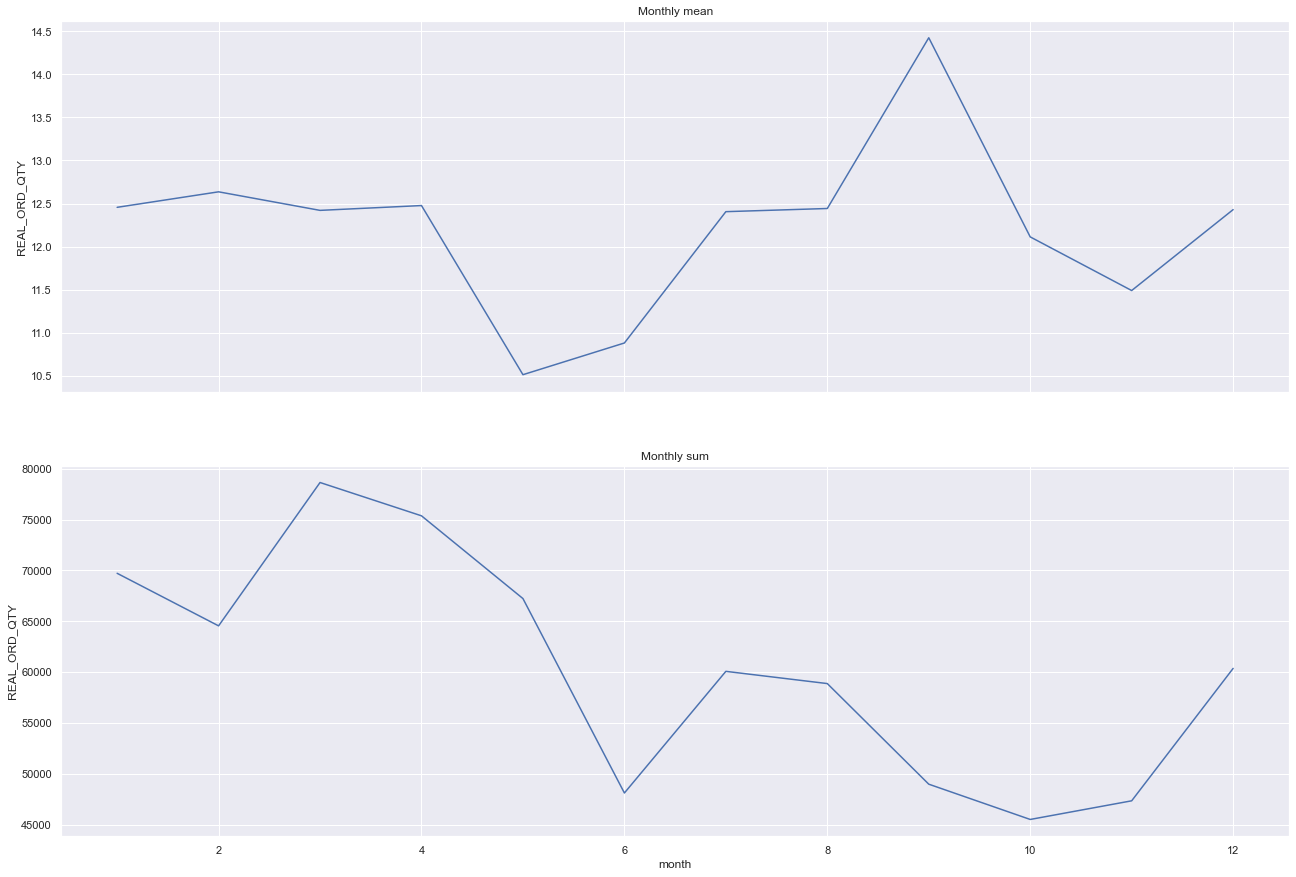

In [1844]:
f, axes = plt.subplots(2, 1, figsize=(22, 15), sharex=True)
sns.lineplot(x="month", y="REAL_ORD_QTY", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="REAL_ORD_QTY", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### 상품별 최종 주문량 그래프

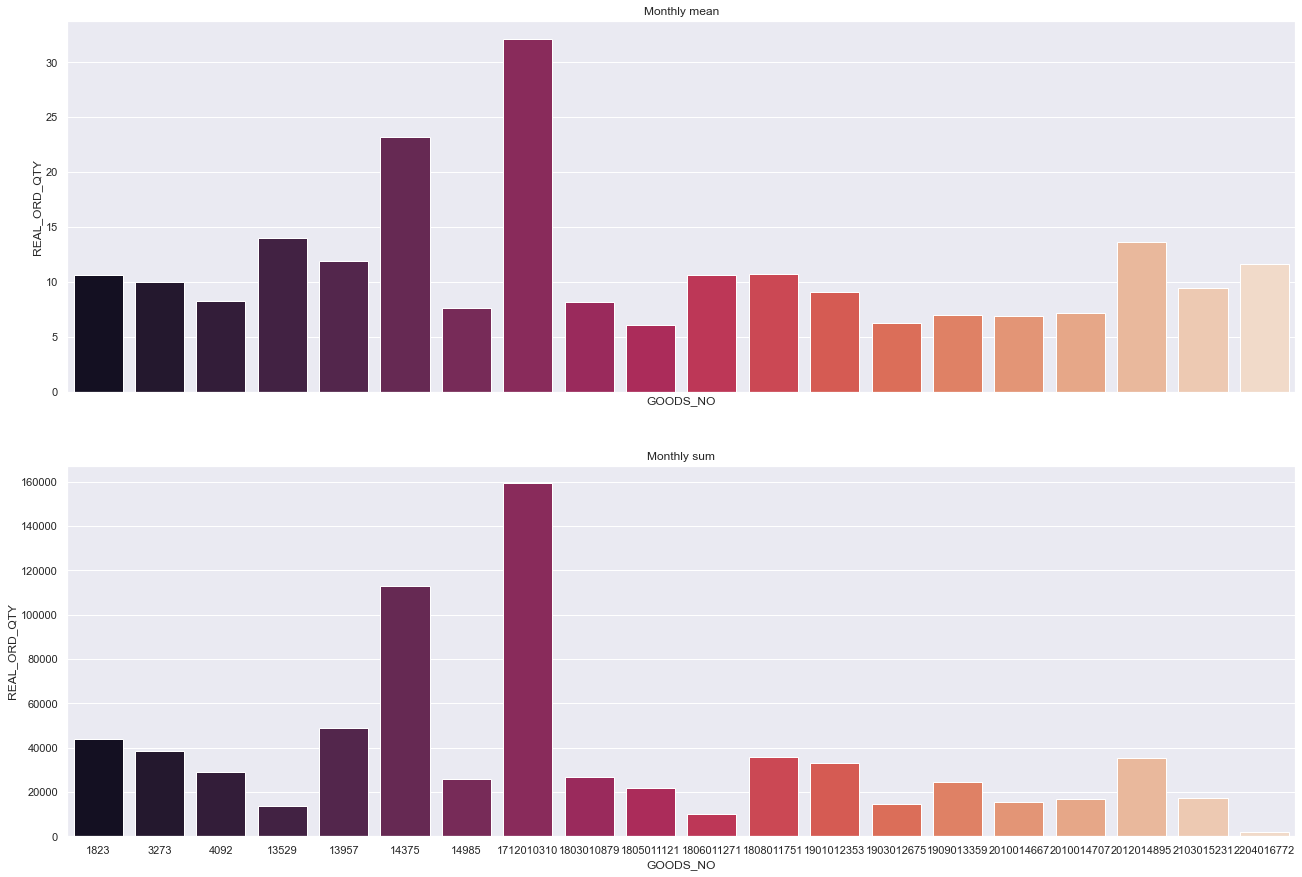

In [1529]:
f, axes = plt.subplots(2, 1, figsize=(22, 15), sharex=True)
sns.barplot(x="GOODS_NO", y="REAL_ORD_QTY", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="GOODS_NO", y="REAL_ORD_QTY", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### 최종 주문량 분석

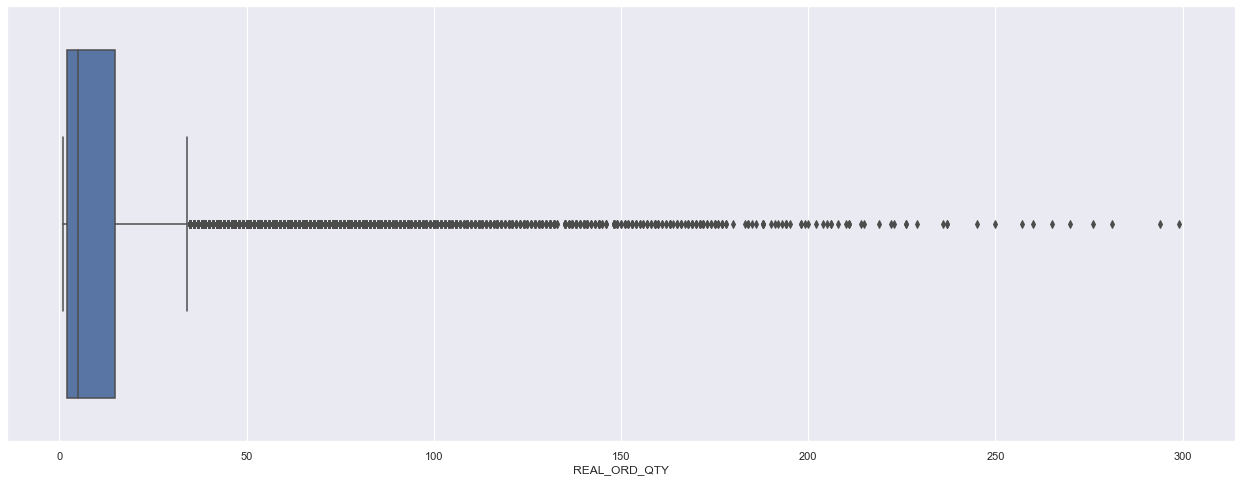

In [1530]:
plt.subplots(figsize=(22, 8))
sns.boxplot(copy_data['REAL_ORD_QTY'])
plt.show()

## 라벨 생성

In [1343]:
copy_data.isna().sum()

H_YMD                  0
GOODS_NO               0
SALE_PRICE             0
mean_sale_price        0
ORD_QTY                0
mean_ord_qty           0
ord_transactions       0
CANCEL_QTY             0
mean_cancel_qty        0
cancel_transactions    0
RET_QTY                0
mean_ret_qty           0
ret_transactions       0
REAL_ORD_QTY           0
year                   0
month                  0
day                    0
dtype: int64

In [1845]:
# 일별 판매량 데이터를 생성한다
# shift() 메서드를 통해 내일 판매량을 땡겨온다

# 한달 데이터 예측
# copy_data['item_cnt_day'] = copy_data.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['REAL_ORD_QTY'].shift(-1)

# 일주일 데이터 예측
copy_data['item_cnt_day'] = copy_data.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['REAL_ORD_QTY'].shift(-6)

In [1846]:
shift_data = copy_data.copy()

shift_data

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,mean_real_ord_qty,year,month,day,item_cnt_day
0,2020-01-01,0,1823,52800,3300.00,3,0.19,0,0.00,16,1.00,2020,1,1,2.00
1,2020-01-01,0,3273,42000,4200.00,1,0.10,0,0.00,10,1.00,2020,1,1,2.00
2,2020-01-01,0,4092,16000,4000.00,0,0.00,0,0.00,4,1.00,2020,1,1,1.00
3,2020-01-01,0,13957,68600,4900.00,3,0.21,0,0.00,14,1.00,2020,1,1,7.00
4,2020-01-01,0,14375,369800,8600.00,1,0.02,0,0.00,43,1.00,2020,1,1,106.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59586,2022-05-31,6,2010014667,32500,6500.00,0,0.00,0,0.00,5,1.00,2022,5,31,NaN
59587,2022-05-31,6,2010014707,144000,9600.00,0,0.00,0,0.00,15,1.00,2022,5,31,NaN
59588,2022-05-31,6,2012014895,256500,13500.00,0,0.00,0,0.00,19,1.00,2022,5,31,NaN
59589,2022-05-31,6,2103015231,99000,9900.00,0,0.00,0,0.00,10,1.00,2022,5,31,NaN


## 피쳐 엔지니어링

In [1847]:
# 판매가격 구성단위 변수 생성
# 판매가격을 최종 주문건수르 나눈 item_price_unit 변수를 생성한다.

shift_data['item_price_unit'] = shift_data['SALE_PRICE'] // shift_data['REAL_ORD_QTY']
shift_data['item_price_unit'].fillna(0, inplace=True)

In [1848]:
# 각 제품의 최솟값과 최댓값을 변수로 넣어준다.(가격별 상승, 하강 추이를 파악하기 위해)

gp_item_price = shift_data.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'], as_index=False).agg({'SALE_PRICE':[np.min, np.max]})
gp_item_price.columns = ['O_YMD', 'GOODS_NO', 'hist_min_item_price', 'hist_max_item_price']

shift_data = pd.merge(shift_data, gp_item_price, on=['O_YMD','GOODS_NO'], how='left')

In [1849]:
# 판매액에서 최솟값을 빼 상승값으로 넣어주고
# 판매액에서 최댓값을 빼 하강값으로 넣어준다.

shift_data['price_increase'] = shift_data['SALE_PRICE'] - shift_data['hist_min_item_price']
shift_data['price_decrease'] = shift_data['hist_max_item_price'] - shift_data['SALE_PRICE']

In [1850]:
fe_data = shift_data.copy()

fe_data.head()

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,mean_real_ord_qty,year,month,day,item_cnt_day,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,2020-01-01,0,1823,52800,3300.00,3,0.19,0,0.00,16,1.00,2020,1,1,2.00,3300,3300,226400,49500,173600
1,2020-01-01,0,3273,42000,4200.00,1,0.10,0,0.00,10,1.00,2020,1,1,2.00,4200,3700,264600,38300,222600
2,2020-01-01,0,4092,16000,4000.00,0,0.00,0,0.00,4,1.00,2020,1,1,1.00,4000,3400,276000,12600,260000
3,2020-01-01,0,13957,68600,4900.00,3,0.21,0,0.00,14,1.00,2020,1,1,7.00,4900,4400,328300,64200,259700
4,2020-01-01,0,14375,369800,8600.00,1,0.02,0,0.00,43,1.00,2020,1,1,106.00,8600,8600,1909200,361200,1539400


## rolling

In [1851]:
# 몇개의 데이터를 가지고 연산을 할 것인가
# 데이터들을 순차적으로 3달 (window=3)씩 선택해서 mean처럼 이동평균을 냄
# 3일치의 min,max,std도 고려할 수 있습니다. 

# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    fe_data[('REAL_ORD_QTY_%s' % function_name[i])] = fe_data.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['REAL_ORD_QTY'].apply(function_list[i])


In [1852]:
# Fill the empty std features with 0
fe_data['REAL_ORD_QTY_std'].fillna(0, inplace=True)

In [1853]:
rolling_data = fe_data.copy()

rolling_data

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,...,item_cnt_day,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,REAL_ORD_QTY_min,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std
0,2020-01-01,0,1823,52800,3300.00,3,0.19,0,0.00,16,...,2.00,3300,3300,226400,49500,173600,16.00,16.00,16.00,0.00
1,2020-01-01,0,3273,42000,4200.00,1,0.10,0,0.00,10,...,2.00,4200,3700,264600,38300,222600,10.00,10.00,10.00,0.00
2,2020-01-01,0,4092,16000,4000.00,0,0.00,0,0.00,4,...,1.00,4000,3400,276000,12600,260000,4.00,4.00,4.00,0.00
3,2020-01-01,0,13957,68600,4900.00,3,0.21,0,0.00,14,...,7.00,4900,4400,328300,64200,259700,14.00,14.00,14.00,0.00
4,2020-01-01,0,14375,369800,8600.00,1,0.02,0,0.00,43,...,106.00,8600,8600,1909200,361200,1539400,43.00,43.00,43.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59586,2022-05-31,6,2010014667,32500,6500.00,0,0.00,0,0.00,5,...,NaN,6500,6200,410700,26300,378200,1.00,9.00,5.00,4.00
59587,2022-05-31,6,2010014707,144000,9600.00,0,0.00,0,0.00,15,...,NaN,9600,6720,595200,137280,451200,1.00,15.00,6.33,7.57
59588,2022-05-31,6,2012014895,256500,13500.00,0,0.00,0,0.00,19,...,NaN,13500,12800,1367400,243700,1110900,2.00,19.00,9.67,8.62
59589,2022-05-31,6,2103015231,99000,9900.00,0,0.00,0,0.00,10,...,NaN,9900,8820,1098580,90180,999580,1.00,10.00,5.33,4.51


## lag

In [1854]:
# 시점을 1일, 2일, 3일로 미뤄서 lag 변수를 생성해준다.

lag_list = [6, 12, 18]

for lag in lag_list:
    ft_name = ('REAL_ORD_QTY_shifted%s' % lag)
    #train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
    rolling_data[ft_name] = rolling_data.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
    # Fill the empty shifted features with 0
    rolling_data[ft_name].fillna(0, inplace=True)

In [1855]:
lag_data = rolling_data.copy()

lag_data.head()

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,...,hist_max_item_price,price_increase,price_decrease,REAL_ORD_QTY_min,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std,REAL_ORD_QTY_shifted6,REAL_ORD_QTY_shifted12,REAL_ORD_QTY_shifted18
0,2020-01-01,0,1823,52800,3300.00,3,0.19,0,0.00,16,...,226400,49500,173600,16.00,16.00,16.00,0.00,0.00,0.00,0.00
1,2020-01-01,0,3273,42000,4200.00,1,0.10,0,0.00,10,...,264600,38300,222600,10.00,10.00,10.00,0.00,0.00,0.00,0.00
2,2020-01-01,0,4092,16000,4000.00,0,0.00,0,0.00,4,...,276000,12600,260000,4.00,4.00,4.00,0.00,0.00,0.00,0.00
3,2020-01-01,0,13957,68600,4900.00,3,0.21,0,0.00,14,...,328300,64200,259700,14.00,14.00,14.00,0.00,0.00,0.00,0.00
4,2020-01-01,0,14375,369800,8600.00,1,0.02,0,0.00,43,...,1909200,361200,1539400,43.00,43.00,43.00,0.00,0.00,0.00,0.00


## trend 반영

In [1856]:
# lag 시켰을 때 나온 item_count 판매량을 lag로 나눠서 1을 더해준다.
lag_list = [6, 12, 18]
lag_data['item_trend'] = lag_data['REAL_ORD_QTY']

for lag in lag_list:
    ft_name = ('REAL_ORD_QTY_shifted%s' % lag)
    lag_data['item_trend'] -= lag_data[ft_name]

lag_data['item_trend'] /= len(lag_list) + 1

In [1857]:
lag_data.describe().T

,count,mean,std,min,25%,50%,75%,max
O_YMD,59591.00,2.94,2.01,0.00,1.00,3.00,5.00,6.00
GOODS_NO,59591.00,1094876631.77,930558534.46,1823.00,13957.00,1712010310.00,1903012675.00,2204016772.00
SALE_PRICE,59591.00,88312.22,150888.15,2600.00,12000.00,35600.00,96000.00,2293200.00
mean_sale_price,59591.00,7067.23,2598.50,2600.00,4500.00,6800.00,8900.00,13500.00
CANCEL_QTY,59591.00,0.62,4.00,0.00,0.00,0.00,1.00,775.00
mean_cancel_qty,59591.00,0.07,0.26,0.00,0.00,0.00,0.05,25.00
RET_QTY,59591.00,0.05,0.37,0.00,0.00,0.00,0.00,25.00
mean_ret_qty,59591.00,0.00,0.05,0.00,0.00,0.00,0.00,2.00
REAL_ORD_QTY,59591.00,12.16,18.92,1.00,2.00,5.00,15.00,299.00
mean_real_ord_qty,59591.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


In [1858]:
final_data = lag_data.copy()

final_data.head()

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,...,price_increase,price_decrease,REAL_ORD_QTY_min,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std,REAL_ORD_QTY_shifted6,REAL_ORD_QTY_shifted12,REAL_ORD_QTY_shifted18,item_trend
0,2020-01-01,0,1823,52800,3300.00,3,0.19,0,0.00,16,...,49500,173600,16.00,16.00,16.00,0.00,0.00,0.00,0.00,4.00
1,2020-01-01,0,3273,42000,4200.00,1,0.10,0,0.00,10,...,38300,222600,10.00,10.00,10.00,0.00,0.00,0.00,0.00,2.50
2,2020-01-01,0,4092,16000,4000.00,0,0.00,0,0.00,4,...,12600,260000,4.00,4.00,4.00,0.00,0.00,0.00,0.00,1.00
3,2020-01-01,0,13957,68600,4900.00,3,0.21,0,0.00,14,...,64200,259700,14.00,14.00,14.00,0.00,0.00,0.00,0.00,3.50
4,2020-01-01,0,14375,369800,8600.00,1,0.02,0,0.00,43,...,361200,1539400,43.00,43.00,43.00,0.00,0.00,0.00,0.00,10.75


## 데이터 분할

In [1860]:
H_YMD = final_data['H_YMD'] # 추후 반영될 날짜 데이터
G_N = final_data['GOODS_NO'] # 추후 반영될 상품번호 데이터

final_data.set_index('H_YMD', inplace=True)

KeyError: 'H_YMD'

In [1861]:
test_set = final_data[(final_data.year == 2022) & (final_data.month == 5)] # 2022년 5월 데이터를 테스트셋으로 설정

idx = final_data[(final_data.year == 2022) & (final_data.month == 5)].index # 2022년 5월 데이터의 인덱스 저장
final_data.drop(idx, inplace=True)                                          # 2022년 5월 데이터 삭제  

train_set = final_data[:7307]            # 남은 데이터의 70%를 학습데이터로 설정         
validation_set = final_data[7307:]       # 남은 데이터의 30%를 학습 데이터로 설정

train_set.dropna(subset=['REAL_ORD_QTY'], inplace=True)  # train 셋에서 일별 판매 데이터 제거
validation_set.dropna(subset=['REAL_ORD_QTY'], inplace=True) # val 셋에서 일별 판매 데이터 제거

train_set.dropna(inplace=True) 
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 7307
Validation set records: 49829
Test set records: 2453
Train set records: 7307 (2% of complete data)
Validation set records: 49829 (16% of complete data)


In [1862]:
test_set

,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,REAL_ORD_QTY,mean_real_ord_qty,...,price_increase,price_decrease,REAL_ORD_QTY_min,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std,REAL_ORD_QTY_shifted6,REAL_ORD_QTY_shifted12,REAL_ORD_QTY_shifted18,item_trend
H_YMD,,,,,,,,,,,,,,,,,,,,,
2022-05-02,0,1823,6600,3300.00,0,0.00,0,0.00,2,1.00,...,3300,219800,1.00,2.00,1.67,0.58,3.00,2.00,24.00,-6.75
2022-05-02,0,3273,8400,4200.00,0,0.00,0,0.00,2,1.00,...,4700,256200,1.00,2.00,1.33,0.58,3.00,2.00,2.00,-1.25
2022-05-02,0,13957,9800,4900.00,0,0.00,0,0.00,2,1.00,...,5400,318500,1.00,4.00,2.33,1.53,1.00,1.00,5.00,-1.25
2022-05-02,0,1712010310,7800,7800.00,0,0.00,0,0.00,1,1.00,...,1170,1995900,1.00,8.00,5.33,3.79,3.00,2.00,1.00,-1.25
2022-05-02,0,1901012353,6900,6900.00,0,0.00,0,0.00,1,1.00,...,600,312700,1.00,1.00,1.00,0.00,1.00,25.00,28.00,-13.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,6,2010014667,32500,6500.00,0,0.00,0,0.00,5,1.00,...,26300,378200,1.00,9.00,5.00,4.00,1.00,5.00,3.00,-1.00
2022-05-31,6,2010014707,144000,9600.00,0,0.00,0,0.00,15,1.00,...,137280,451200,1.00,15.00,6.33,7.57,1.00,1.00,4.00,2.25
2022-05-31,6,2012014895,256500,13500.00,0,0.00,0,0.00,19,1.00,...,243700,1110900,2.00,19.00,9.67,8.62,36.00,17.00,21.00,-13.75


In [1863]:
# 학습데이터의 상품번호 별 일별 판매량 평균
gp_goods_mean_t = train_set.groupby(['O_YMD','GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_goods_mean_t.columns = ['GOODS_mean']
gp_goods_mean_t.reset_index(inplace=True)
# 검증데이터의 상품번호 별 일별 판매량 평균
gp_goods_mean_v = validation_set.groupby(['O_YMD','GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_goods_mean_v.columns = ['GOODS_mean']
gp_goods_mean_v.reset_index(inplace=True)

# 핛습데이터의 연도별 일별 판매량 평균
gp_year_mean_t = train_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean_t.columns = ['year_mean']
gp_year_mean_t.reset_index(inplace=True)
# 검증데이터의 연도별 일별 판매량 평균
gp_year_mean_v = validation_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean_v.columns = ['year_mean']
gp_year_mean_v.reset_index(inplace=True)

# 학습데이터의 월별 일별 판매량 평균
gp_month_mean_t = train_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean_t.columns = ['month_mean']
gp_month_mean_t.reset_index(inplace=True)
# 검증데이터의 월별 일별 판매량 평균
gp_month_mean_v = validation_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean_v.columns = ['month_mean']
gp_month_mean_v.reset_index(inplace=True)

# 훈련 데이터에 판매량 평균 데이터들 결함
train_set = pd.merge(train_set, gp_goods_mean_t, on=['O_YMD','GOODS_NO'], how='left')
train_set = pd.merge(train_set, gp_year_mean_t, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean_t, on=['month'], how='left')

# 검증 데이터에 판매량 평균 데이터들 결함
validation_set = pd.merge(validation_set, gp_goods_mean_v, on=['O_YMD','GOODS_NO'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean_v, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean_v, on=['month'], how='left')

In [1864]:
# 훈련데이터에서 일별 판매량과 월 단위 데이터를 제거 
# 타겟에 제거한 일별 데이터를 삽입

X_train = train_set.drop(['REAL_ORD_QTY'], axis=1)
y_train = train_set['REAL_ORD_QTY'].astype(int)

# 검증데이터에서 일별 판매량과 월 단위 데이터를 제거 
# 타겟에 제거한 일별 데이터를 삽입

X_val = validation_set.drop(['REAL_ORD_QTY'], axis=1)
y_val = validation_set['REAL_ORD_QTY'].astype(int)

In [1865]:
# Integer features (used by catboost model).
int_features = ['GOODS_NO', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_val[int_features] = X_val[int_features].astype('int32')

In [1866]:
# 상품별 일별 판매량 평균
gp_shop_mean = test_set.groupby(['O_YMD','GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_shop_mean.columns = ['GOODS_mean']
gp_shop_mean.reset_index(inplace=True)

# 연도별 일별 판매량 평균
gp_year_mean = test_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# 월별 일별 판매량 평균
gp_month_mean = test_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# 테스트 셋에도 해당 데이터들을 삽입
test_set = pd.merge(test_set, gp_shop_mean, on=['O_YMD','GOODS_NO'], how='left')
test_set = pd.merge(test_set, gp_year_mean, on=['year'], how='left')
test_set = pd.merge(test_set, gp_month_mean, on=['month'], how='left')

In [1778]:
train_set.columns

Index(['O_YMD', 'GOODS_NO', 'SALE_PRICE', 'mean_sale_price', 'CANCEL_QTY',
       'mean_cancel_qty', 'RET_QTY', 'mean_ret_qty', 'REAL_ORD_QTY',
       'mean_real_ord_qty', 'year', 'month', 'day', 'item_cnt_day',
       'item_price_unit', 'hist_min_item_price', 'hist_max_item_price',
       'price_increase', 'price_decrease', 'REAL_ORD_QTY_min',
       'REAL_ORD_QTY_max', 'REAL_ORD_QTY_mean', 'REAL_ORD_QTY_std',
       'REAL_ORD_QTY_shifted1', 'REAL_ORD_QTY_shifted2',
       'REAL_ORD_QTY_shifted3', 'item_trend', 'GOODS_mean', 'year_mean',
       'month_mean'],
      dtype='object')

In [1867]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['GOODS_NO'], keep='last')
X_test = test_set

y_test = test_set['REAL_ORD_QTY']    # 타겟 데이터에 일별 판매량 삽입
X_test.drop('REAL_ORD_QTY', axis=1, inplace=True)  # 테스트 데이터에서 일별 판매량 제거

X_test = X_test[X_train.columns]

In [1868]:
sets = [X_train, X_val, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for goods_no in dataset['GOODS_NO'].unique():
        for column in dataset.columns:
            goods_median = dataset[(dataset['GOODS_NO'] == goods_no)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['GOODS_NO'] == goods_no), column] = goods_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [1781]:
X_test.head()

,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,CANCEL_QTY,mean_cancel_qty,RET_QTY,mean_ret_qty,mean_real_ord_qty,year,...,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std,REAL_ORD_QTY_shifted1,REAL_ORD_QTY_shifted2,REAL_ORD_QTY_shifted3,item_trend,GOODS_mean,year_mean,month_mean
0,0,1823,6600,3300.00,0,0.00,0,0.00,1.00,2022,...,2.00,1.67,0.58,1.00,2.00,17.00,-4.50,17.35,10.70,10.70
1,0,3273,8400,4200.00,0,0.00,0,0.00,1.00,2022,...,2.00,1.33,0.58,1.00,1.00,2.00,-0.50,16.95,10.70,10.70
2,0,13957,9800,4900.00,0,0.00,0,0.00,1.00,2022,...,4.00,2.33,1.53,1.00,4.00,4.00,-1.75,16.32,10.70,10.70
3,0,1712010310,7800,7800.00,0,0.00,0,0.00,1.00,2022,...,8.00,5.33,3.79,7.00,8.00,4.00,-4.50,30.00,10.70,10.70
4,0,1901012353,6900,6900.00,0,0.00,0,0.00,1.00,2022,...,1.00,1.00,0.00,1.00,1.00,10.00,-2.75,11.47,10.70,10.70


In [1782]:
X_train.columns

Index(['O_YMD', 'GOODS_NO', 'SALE_PRICE', 'mean_sale_price', 'CANCEL_QTY',
       'mean_cancel_qty', 'RET_QTY', 'mean_ret_qty', 'mean_real_ord_qty',
       'year', 'month', 'day', 'item_cnt_day', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'REAL_ORD_QTY_min', 'REAL_ORD_QTY_max',
       'REAL_ORD_QTY_mean', 'REAL_ORD_QTY_std', 'REAL_ORD_QTY_shifted1',
       'REAL_ORD_QTY_shifted2', 'REAL_ORD_QTY_shifted3', 'item_trend',
       'GOODS_mean', 'year_mean', 'month_mean'],
      dtype='object')

In [1870]:
# Use only part of features on XGBoost.
# xgb_features = ['REAL_ORD_QTY','REAL_ORD_QTY_mean', 'REAL_ORD_QTY_std', 
#                 'REAL_ORD_QTY_shifted1', 'REAL_ORD_QTY_shifted2', 'REAL_ORD_QTY_shifted3', 
#                 'GOODS_mean','item_trend', 'mean_real_ord_qty']

# xgb_features = ['O_YMD', 'ORD_QTY','ORD_QTY_mean', 'ORD_QTY_std', 
#                 'CANCEL_QTY', 'mean_cancel', 'cancel_transactions',
#                 'RET_QTY', 'mean_ret_qty', 'ret_qty_transactions',
#                 'ORD_QTY_shifted1', 'ORD_QTY_shifted2', 'ORD_QTY_shifted3', 
#                 'GOODS_mean','item_trend']

xgb_features = ['O_YMD','REAL_ORD_QTY_mean', 'REAL_ORD_QTY_std', 
                'CANCEL_QTY', 'mean_cancel_qty', 
                'RET_QTY', 'mean_ret_qty', 
                'REAL_ORD_QTY_shifted6', 'REAL_ORD_QTY_shifted12', 'REAL_ORD_QTY_shifted18', 
                'GOODS_mean','item_trend']

xgb_train = X_train[xgb_features]
xgb_val = X_val[xgb_features]
xgb_test = X_test[xgb_features]

In [1871]:
xgb_model = XGBRegressor(max_depth=3, 
                         n_estimators=1000, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.1, 
                         seed=0)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, y_train), (xgb_val, y_val)], 
              verbose=20, 
              early_stopping_rounds=30)

[0]	validation_0-rmse:20.21740	validation_1-rmse:21.51832
[20]	validation_0-rmse:14.35028	validation_1-rmse:15.57448
[40]	validation_0-rmse:13.16636	validation_1-rmse:14.29529
[60]	validation_0-rmse:12.54086	validation_1-rmse:13.64815
[80]	validation_0-rmse:12.14614	validation_1-rmse:13.28715
[100]	validation_0-rmse:11.86922	validation_1-rmse:13.01591
[120]	validation_0-rmse:11.65228	validation_1-rmse:12.86211
[140]	validation_0-rmse:11.47747	validation_1-rmse:12.70356
[160]	validation_0-rmse:11.32905	validation_1-rmse:12.58169
[180]	validation_0-rmse:11.20572	validation_1-rmse:12.47488
[200]	validation_0-rmse:11.10765	validation_1-rmse:12.40104
[220]	validation_0-rmse:11.01864	validation_1-rmse:12.32634
[240]	validation_0-rmse:10.94180	validation_1-rmse:12.25044
[260]	validation_0-rmse:10.87532	validation_1-rmse:12.20081
[280]	validation_0-rmse:10.81772	validation_1-rmse:12.15159
[300]	validation_0-rmse:10.75618	validation_1-rmse:12.11275
[320]	validation_0-rmse:10.69940	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

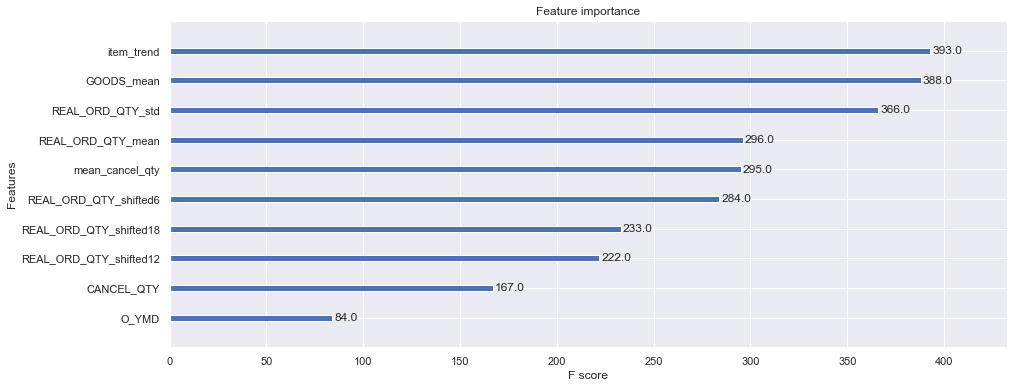

In [1872]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [1873]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [1874]:
from sklearn.metrics import r2_score

print('r2:', r2_score(y_test, xgb_test_pred))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, xgb_val_pred)))

r2: 0.657680195971411
Train rmse: 10.054377371094986
Validation rmse: 11.604166135683903


In [1875]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [1876]:
def to_csv(df, x_test, H_YMD):
    H_YMD = pd.DataFrame(H_YMD)
    test_h_ymd = H_YMD[-(len(x_test)):]
    test_h_ymd.reset_index(drop=True, inplace=True)

    df = pd.DataFrame(df)
    df['GOODS_NO'] = x_test.GOODS_NO
    df['H_YMD'] = test_h_ymd
    df.columns = ['item_cnt_day', 'GOODS_NM', 'H_YMD']

    for n in GOODS_DIC.keys():
        df['GOODS_NM'].loc[df['GOODS_NM'] == n ] = GOODS_DIC[n]

    resampled = df.groupby('GOODS_NM').resample(rule='1D', on='H_YMD')
    resampled.sum()

    df = resampled.sum()

    return df


In [1877]:
xgb_result = to_csv(xgb_test_pred, X_test, H_YMD)
y_result = to_csv(y_test, X_test, H_YMD)

In [1878]:
y_result.to_csv('C:\\Users\\user\\Desktop\\y_result.csv', encoding='utf-8-sig')
xgb_result.to_csv('C:\\Users\\user\\Desktop\\xgb_result.csv', encoding='utf-8-sig')

In [1666]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [1879]:
def evaluate_regr(y, pred):
    mse = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mse)
    mae_val = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('RMSE : {} | MAE : {} | r2 : {} '.format(round(rmse_val,5),round(mae_val,5),round(r2,5)))

# 여러 모델의 성능 확인 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#--------------------------------------------------------------------
#모델별로 평가 확인 

ridge_reg = Ridge(alpha=0)      # best alpha = 0
lasso_reg = Lasso(alpha=1)        # best alpha = 1
tree_reg = DecisionTreeRegressor(random_state=13)
forest_reg = RandomForestRegressor(n_estimators=100,random_state=13)

for model in [ridge_reg, lasso_reg,tree_reg,forest_reg]:
# for model in [forest_reg]:
    get_model_predict(model, X_train, X_val, y_train, y_val)

### Ridge ###
RMSE : 0.0 | MAE : 0.0 | r2 : 1.0 
### Lasso ###
RMSE : 3.59329 | MAE : 2.1303 | r2 : 0.96511 
### DecisionTreeRegressor ###
RMSE : 3.02839 | MAE : 0.68534 | r2 : 0.97522 
### RandomForestRegressor ###
RMSE : 2.20463 | MAE : 0.56471 | r2 : 0.98687 


In [1880]:
pd.DataFrame([X_train.columns, lasso_reg.coef_]).T

,0,1
0,O_YMD,-0.00
1,GOODS_NO,0.00
2,SALE_PRICE,0.00
3,mean_sale_price,-0.00
4,CANCEL_QTY,0.00
5,mean_cancel_qty,-0.00
6,RET_QTY,0.00
7,mean_ret_qty,-0.00
8,mean_real_ord_qty,0.00
9,year,0.00


In [1424]:
lasso_reg.coef_[

-4.56202932049952e-12